In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


The classical Lax-Friedrichs (LxF) method has the form

\begin{equation}
Q_{i}^{n+1} = \frac{1}{2}(Q_{i-1}^{n} + Q_{i+1}^{n}) - \frac{\Delta t}{2\Delta x}[f(Q_{i+1}^{n}) - f(Q_{i-1}^{n})]
\end{equation}



In [2]:
hl = 2
hr = 1
ul = 0
ur = 0

g = 1
#intial data
ql = array([hl,hl*ul])
qr = array([hr,hr*ur])

# Spatial domain
ax = -5
bx = 5
ay = -2
by = 4
meqn = 2  # Number of equations in the system

# Gravity
g = 1

# Temporal domain
to = 0
Tfinal = 2

#intial data
ql = array([hl,hl*ul])
qr = array([hr,hr*ur])

N = 256

dx = (bx - ax)/N

cfl = 0.9

a = 1.7

dt_est = cfl*dx/a

M = int(floor(Tfinal/dt_est) + 1)

dt = Tfinal/(M)


t = linspace(to,Tfinal,M)

#x = linspace(ax+(dx/2),bx-(dx/2),N)

xe = linspace(ax,bx,N+1) #edge locations
x = xe[:-1] + dx/2       #Cell-center locations
M

97

In [3]:
from exact_rp import *

#rarefaction solution
hmr,umr = rare(ql,qr,g)

#shock solution
hms,ums = newton(ql,qr,g)

#intermediate states
qmr = array([hmr,hmr*umr])
qms = array([hms,hms*ums])

In [4]:
abs(umr + sqrt(g*hmr))

1.6213203435596428

In [5]:
#flux
def flux(q):
    '''
    input:
    -----
    q - state at the interface
    return:
    -------
    f - flux at the interface
    '''
    q1 = q[0]
    q2 = q[1]
    f = zeros(2)
    f[0] = q2
    f[1] = (((q2)**2)/q1) + (0.5*g*(q1)**2)
    return f

def flu(q1,q2):
    f1 = lambda q1,q2: q2
    f2 = lambda q1,q2: (((q2)**2)/q1) + (0.5*g*(q1)**2)
    return f1,f2

In [6]:
#neumannBoundaryConditions
def Newman(var):
    ### NEUMANN BC ###
    var[0]=var[1]
    var[-1]=var[-2]
    return var

def addGhostCells(var):
    return hstack([0.,var,0.])

In [7]:
def timestep(dx,s,v,g,h):
    max1 = max(abs(v + sqrt(g*h)))
    max2 = max(abs(v - sqrt(g*h)))
    maxo = max(max1,max2) #max wave speed
    
    dt = s*dx/maxo
    return dt
    

In [8]:
#Initial conditions
qold1 = zeros(N)
qold2 = zeros(N)
qnew1 = zeros(N)
qnew2 = zeros(N)

qold1 = where(x <= 0 , ql[0], qr[0])
qold2 = where(x <= 0 , ql[1], qr[1]) 


<IPython.core.display.Javascript object>


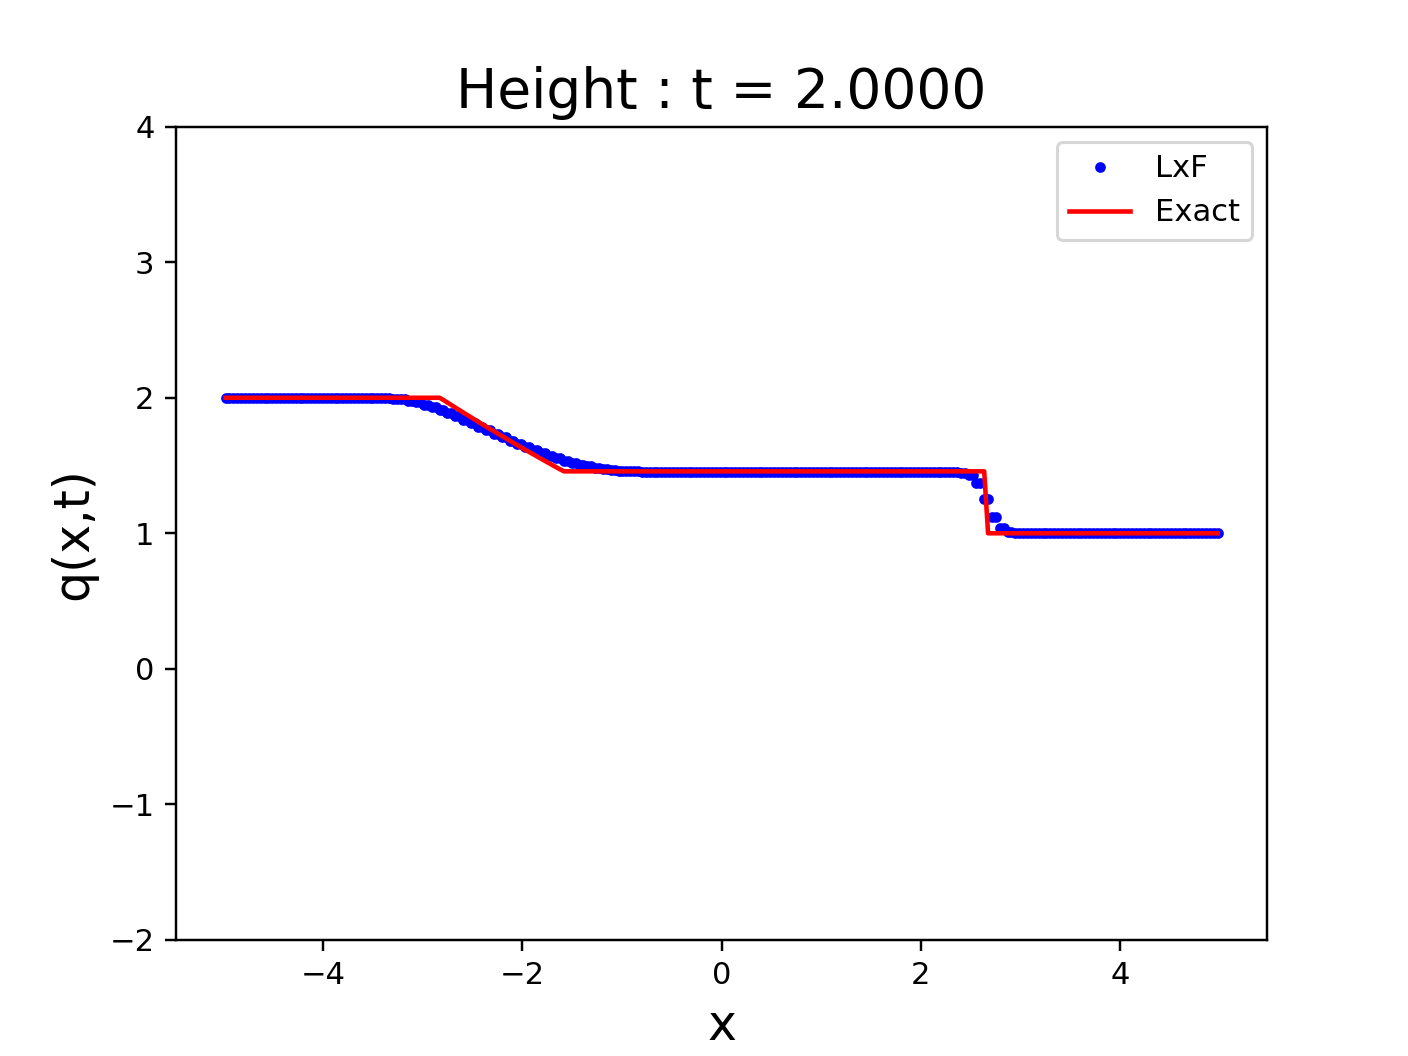

In [9]:
fig = figure(1)
clf()

mq =0

if mq == 0:
    tstr = 'Height : t = {:.4f}'
    hdl, = plot(x,qold1,'b.',markersize=5,label='LxF')
else:
    tstr = 'Momentum : t = {:.4f}'
    hdl, = plot(x,qold2,'b.',markersize=5,label='LxF')

htitle = title(tstr.format(0),fontsize=18)

q0 = qexact(x,to,mq,ql,qr,g)

hde, = plot(x,q0,'r-',markersize=5,label='Exact')


for n in range(M):
    #exact solver
    q = qexact(x,t[n],mq,ql,qr,g)
    
    hde.set_ydata(q)
    
    smax = 0
    for i in range(N):
        if i == N-1:
            q1l = array([qold1[i],qold2[i]])
            q1r = array([qold1[i],qold2[i]])
        else:
            q1l = array([qold1[i],qold2[i]])
            q1r = array([qold1[i+1],qold2[i+1]])
        
        #f_{i+1/2}
        f1 = 0.5*(flux(q1l) + flux(q1r) - (dx/dt)*(q1r - q1l))
        
        sm = abs(q1l[1]/q1l[0] - sqrt(g*q1l[0]))
        sp = abs(q1r[1]/q1r[0] + sqrt(g*q1r[0]))
        smax = max(sm,sp)
        
        if i == 0:
            q2l = array([qold1[i],qold2[i]])
            q2r = array([qold1[i],qold2[i]])
        else:
            q2l = array([qold1[i-1],qold2[i-1]])
            q2r = array([qold1[i],qold2[i]])
        
        #f_{i-1/2}
        f2 = 0.5*(flux(q2l) + flux(q2r) - (dx/dt)*(q2r - q2l)) 
        
        sm = abs(q2l[1]/q2l[0] - sqrt(g*q2l[0]))
        sp = abs(q2r[1]/q2r[0] + sqrt(g*q2r[0]))
        smax = max(smax,sm,sp)
        #dt = cfl*dx/smax
        
        #soln at N+1
        qnew1[i] = qold1[i] - (dt/dx)*(f1[0] - f2[0])

        qnew2[i] = qold2[i] - (dt/dx)*(f1[1] - f2[1])

    if mq == 0:
        hdl.set_ydata(qnew1)
    else:
        hdl.set_ydata(qnew2)
        
    #overwrite the soln
    qold1 = qnew1.copy()
    qold2 = qnew2.copy()
    
    xlabel('x',fontsize=16)
    ylabel('q(x,t)',fontsize=16)
    htitle.set_text(tstr.format(t[n]))
    
    ylim([ay,by])
    legend()
    pause(0.1)

    fig.canvas.draw()        